In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [15]:
course_df = pd.read_csv('../data/course_prepared.csv', header=0, encoding='unicode_escape')
course_df.drop(columns='Subj', inplace=True)
course_df.head()

,Course,Term,Term Yr,Class Yr,Dept Desc,Cap,Enrolled
0,CSC 111,Fall,2019,1,Computer Science,400,346
1,CSC 115,Fall,2019,1,Computer Science,150,130
2,CSC 115,Summer,2019,1,Computer Science,115,86
3,CSC 225,Fall,2019,2,Computer Science,215,197
4,CSC 225,Summer,2019,2,Computer Science,145,63


In [16]:
X_train, X_test = train_test_split(course_df, test_size=0.4, random_state=42)
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

enrollment = X_train.drop(columns='Enrolled', axis='columns')
enrollment_labels = X_train['Enrolled'].copy()

Train: 132, Test: 88


In [17]:
# Separate our attributes depending on their desired transformations
num_attribs = ['Class Yr', 'Term Yr']
cat_attribs = ['Term', 'Dept Desc']
log_attribs = ['Cap']
basen_attribs = ['Course']

numeric_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder())
])

log_pipeline = Pipeline([
    ('log', FunctionTransformer(np.log, feature_names_out="one-to-one")),
    ('scaler', StandardScaler())
])

basen_pipeline = Pipeline([
    ('base_encoder', ce.BaseNEncoder(base=2, cols=basen_attribs))
])

preprocessing = ColumnTransformer([
    ('numeric_transformer', numeric_pipeline, num_attribs),
    ('categorical_transformer', categorical_pipeline, cat_attribs),
    ('ordinal_transformer', basen_pipeline, basen_attribs),
    ('log_transformer', log_pipeline, log_attribs),
], remainder='passthrough', verbose_feature_names_out=False)

In [18]:
enrollment_prepared = preprocessing.fit_transform(enrollment)

In [19]:
preprocessing.get_feature_names_out()

array(['Class Yr', 'Term Yr', 'Term_Fall', 'Term_Spring', 'Term_Summer',
       'Dept Desc_Computer Science',
       'Dept Desc_Electrical & Computer Engg',
       'Dept Desc_Engineering & Computer Science', 'Course_0', 'Course_1',
       'Course_2', 'Course_3', 'Course_4', 'Cap'], dtype=object)

In [20]:
forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_reg.fit(enrollment, enrollment_labels)

forest_predictions = forest_reg.predict(enrollment)

forest_rmses = -cross_val_score(forest_reg, 
                                enrollment,
                                enrollment_labels,
                                scoring="neg_root_mean_squared_error", 
                                cv=10)

np.mean(forest_rmses)

19.01885685339779

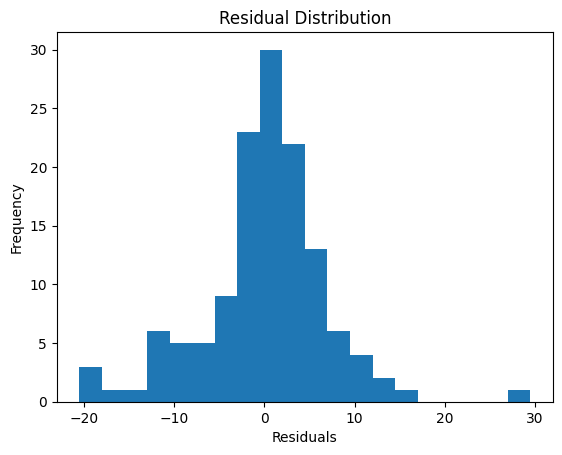

In [21]:
residuals = enrollment_labels - forest_predictions
plt.hist(residuals, bins=20)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()

In [22]:
gb_reg = make_pipeline(preprocessing, GradientBoostingRegressor(random_state=42))
gb_reg.fit(enrollment, enrollment_labels)

gb_predictions = gb_reg.predict(enrollment)

gb_rmses = -cross_val_score(gb_reg, 
                            enrollment, 
                            enrollment_labels, 
                            scoring="neg_root_mean_squared_error", 
                            cv=10)

np.mean(gb_rmses)


18.716953974850856

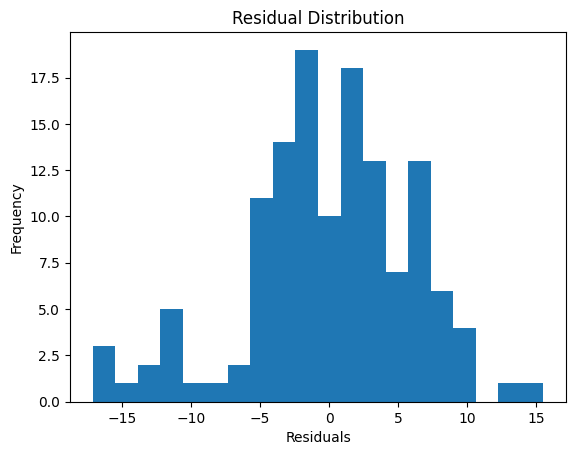

In [23]:
residuals = enrollment_labels - gb_predictions
plt.hist(residuals, bins=20)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()

In [24]:
enrolled_predictions = gb_reg.predict(X_test)
final_mse = mean_squared_error(X_test['Enrolled'], enrolled_predictions, squared=False)
final_mse

43.46630458478708

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ed8b2606-cddb-42a3-87b1-48ea02a39e44' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>